In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import shap
import scikitplot as skplt
from mistune.plugins.math import math
from pyspark.sql.functions import avg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier
from catboost import Pool

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict

from scipy.stats import ks_2samp
from scipy.stats import describe
from imblearn.over_sampling import SMOTENC
from collections import Counter
from IPython.display import display

%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
dataset_base_path = r'E:\PycharmProjects\pythonProject1\iiot2024'


In [3]:
types = {
    'ts': 'float64',  # Timestamp, likely in float format
    'flow_duration': 'float32',  # Same as original
    'Header_Length': 'int64',  # Same as original 'header_length'
    'Source IP': 'object',  # IP addresses as strings
    'Destination IP': 'object',  # IP addresses as strings
    'Source Port': 'int32',  # Ports can be stored as integers
    'Destination Port': 'int32',  # Same as source port
    'Protocol Type': 'int8',  # Assuming small integer range for protocol types
    'Protocol_name': 'object',  # Protocol names as strings
    'Duration': 'float32',  # Same as original 'duration'
    'Rate': 'float32',  # Replacing 'rate'
    'Srate': 'float32',  # Same as original 'srate'
    'Drate': 'float32',  # Same as original 'drate'
    'fin_flag_number': 'uint8',  # Same as original
    'syn_flag_number': 'uint8',  # Same as original
    'rst_flag_number': 'uint8',  # Same as original
    'psh_flag_number': 'uint8',  # Same as original
    'ack_flag_number': 'uint8',  # Same as original
    'urg_flag_number': 'uint8',  # New, inferred from context
    'ece_flag_number': 'uint8',  # Same as original
    'cwr_flag_number': 'uint8',  # Same as original
    'ack_count': 'float32',  # Same as original
    'syn_count': 'float32',  # Same as original
    'fin_count': 'float32',  # Same as original
    'urg_count': 'float32',  # Same as original
    'rst_count': 'float32',  # Same as original
    'max_duration': 'float32',  # New field inferred from context
    'min_duration': 'float32',  # New field inferred from context
    'sum_duration': 'float32',  # New field inferred from context
    'average_duration': 'float32',  # New field inferred from context
    'std_duration': 'float32',  # New field inferred from context
    'CoAP': 'uint8',  # New field, protocol flag
    'HTTP': 'uint8',  # Protocol flag
    'HTTPS': 'uint8',  # Protocol flag
    'DNS': 'uint8',  # Protocol flag
    'Telnet': 'uint8',  # Protocol flag
    'SMTP': 'uint8',  # Protocol flag
    'SSH': 'uint8',  # Protocol flag
    'IRC': 'uint8',  # Protocol flag
    'TCP': 'uint8',  # Protocol flag
    'UDP': 'uint8',  # Protocol flag
    'DHCP': 'uint8',  # Protocol flag
    'ARP': 'uint8',  # Protocol flag
    'ICMP': 'uint8',  # Protocol flag
    'IGMP': 'uint8',  # Protocol flag
    'IPv': 'uint8',  # Protocol flag
    'LLC': 'uint8',  # Protocol flag
    'Tot sum': 'float32',  # Replacing 'tot_sum'
    'Min': 'float32',  # Replacing 'min'
    'Max': 'float32',  # Replacing 'max'
    'AVG': 'float32',  # Replacing 'avg'
    'Std': 'float32',  # Replacing 'std'
    'Tot size': 'float32',  # Replacing 'tot_size'
    'IAT': 'float32',  # Replacing 'iat'
    'Number': 'float32',  # Replacing 'number'
    'MAC': 'object',  # Likely MAC address, stored as a string
    'Magnitue': 'float32',  # Inferred from context
    'Radius': 'float32',  # Same as original 'radius'
    'Covariance': 'float32',  # Same as original 'covariance'
    'Variance': 'float32',  # Same as original 'variance'
    'Weight': 'float32',  # Same as original 'weight'
    'DS status': 'uint8',  # New field, inferred from context
    'Fragments': 'uint8',  # New field, inferred from context
    'Sequence number': 'int64',  # New field, inferred from context
    'Protocol Version': 'int8',  # New field, inferred from context
    'flow_idle_time': 'float32',  # New field, inferred from context
    'flow_active_time': 'float32',  # New field, inferred from context
    'label': 'object',  # Same as original
    'subLabel': 'object',  # New field, inferred from context
    'subLabelCat': 'object'  # New field, inferred from context
}

def replace_infinity_with_mean(df):
    modified_rows = 0
    inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
    for col in inf_columns:
        modified_rows += df[df[col] == np.inf].shape[0]
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df, modified_rows

def replace_negative_values_with_mean(df):
    modified_rows = 0
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values
    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        modified_rows += df[df[col] < 0].shape[0]
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df, modified_rows

def load_dataset(files, dtypes, cols=None):
    df = pd.concat((pd.read_csv(f, dtype=dtypes, usecols=cols) for f in files))

    df, infinity_modified_rows = replace_infinity_with_mean(df)
    df, negative_modified_rows = replace_negative_values_with_mean(df)

    total_modified_rows = infinity_modified_rows + negative_modified_rows
    print(f'عدد السطور المعدلة للقيم اللانهائية: {infinity_modified_rows}')
    print(f'عدد السطور المعدلة للقيم السالبة: {negative_modified_rows}')
    print(f'إجمالي عدد السطور المعدلة: {total_modified_rows}')

    return df

In [4]:
csv_files = glob.glob(os.path.join(dataset_base_path, '*.csv'))

df = load_dataset(csv_files, types)
df

عدد السطور المعدلة للقيم اللانهائية: 0
عدد السطور المعدلة للقيم السالبة: 0
إجمالي عدد السطور المعدلة: 0


,ts,flow_duration,Header_Length,Source IP,Destination IP,Source Port,Destination Port,Protocol Type,Protocol_name,Duration,...,Weight,DS status,Fragments,Sequence number,Protocol Version,flow_idle_time,flow_active_time,label,subLabel,subLabelCat
0,1.701426e+09,0.000000,66,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,1.0,0,0,0,0,1.701426e+09,0.000000,0,0,0
1,1.701426e+09,0.002112,132,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,4.0,0,0,0,0,2.112150e-03,0.002112,0,0,0
2,1.701426e+09,0.002328,198,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,9.0,0,0,0,0,2.160072e-04,0.002328,0,0,0
3,1.701426e+09,0.004329,264,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,16.0,0,0,0,0,2.001047e-03,0.004329,0,0,0
4,1.701426e+09,0.009495,330,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,25.0,0,0,0,0,5.165815e-03,0.009495,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9536818,1.701550e+09,2.018212,5460,172.16.66.128,239.255.255.250,41544,1900,17,UDP,1.0,...,100.0,0,0,0,0,2.312660e-05,2.018212,0,0,0
9536819,1.701550e+09,0.021296,1432,172.16.66.128,172.16.64.128,502,55784,6,TCP,64.0,...,121.0,0,0,0,0,2.112150e-03,0.021296,0,0,0
9536820,1.701550e+09,2.018227,5670,172.16.66.128,239.255.255.250,41544,1900,17,UDP,1.0,...,144.0,0,0,0,0,1.478195e-05,2.018227,0,0,0
9536821,1.701550e+09,2.018277,5880,172.16.66.128,239.255.255.250,41544,1900,17,UDP,1.0,...,169.0,0,0,0,0,5.006790e-05,2.018277,0,0,0


In [5]:
import socket
import struct
import pandas as pd

def ip_to_int(ip_address):
    try:
        return struct.unpack("!I", socket.inet_aton(ip_address))[0]
    except socket.error:
        return None



df['Source IP (int)'] = df['Source IP'].apply(ip_to_int)
df['Destination IP (int)'] = df['Destination IP'].apply(ip_to_int)

print(df)


                   ts  flow_duration  Header_Length      Source IP  \
0        1.701426e+09       0.000000             66  172.16.64.128   
1        1.701426e+09       0.002112            132  172.16.64.128   
2        1.701426e+09       0.002328            198  172.16.64.128   
3        1.701426e+09       0.004329            264  172.16.64.128   
4        1.701426e+09       0.009495            330  172.16.64.128   
...               ...            ...            ...            ...   
9536818  1.701550e+09       2.018212           5460  172.16.66.128   
9536819  1.701550e+09       0.021296           1432  172.16.66.128   
9536820  1.701550e+09       2.018227           5670  172.16.66.128   
9536821  1.701550e+09       2.018277           5880  172.16.66.128   
9536822  1.701550e+09       2.018348           6090  172.16.66.128   

          Destination IP  Source Port  Destination Port  Protocol Type  \
0          172.16.66.128        41750               502              6   
1          

In [6]:
X = df.drop(columns=['label','subLabel','subLabelCat','Source IP','Destination IP','Protocol_name'])
y = df[['label']]

In [7]:
X

,ts,flow_duration,Header_Length,Source Port,Destination Port,Protocol Type,Duration,Rate,Srate,Drate,...,Variance,Weight,DS status,Fragments,Sequence number,Protocol Version,flow_idle_time,flow_active_time,Source IP (int),Destination IP (int)
0,1.701426e+09,0.000000,66,41750,502,6,64.0,0.000000,0.000000,0.0,...,0.0,1.0,0,0,0,0,1.701426e+09,0.000000,2886746240,2886746752
1,1.701426e+09,0.002112,132,41750,502,6,64.0,946.902344,946.902344,0.0,...,0.0,4.0,0,0,0,0,2.112150e-03,0.002112,2886746240,2886746752
2,1.701426e+09,0.002328,198,41750,502,6,64.0,1288.572632,1288.572632,0.0,...,0.0,9.0,0,0,0,0,2.160072e-04,0.002328,2886746240,2886746752
3,1.701426e+09,0.004329,264,41750,502,6,64.0,923.957275,923.957275,0.0,...,0.0,16.0,0,0,0,0,2.001047e-03,0.004329,2886746240,2886746752
4,1.701426e+09,0.009495,330,41750,502,6,64.0,526.591858,526.591858,0.0,...,0.0,25.0,0,0,0,0,5.165815e-03,0.009495,2886746240,2886746752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9536818,1.701550e+09,2.018212,5460,41544,1900,17,1.0,12.882689,12.882689,0.0,...,1.0,100.0,0,0,0,0,2.312660e-05,2.018212,2886746752,4026531834
9536819,1.701550e+09,0.021296,1432,502,55784,6,64.0,939.142456,939.142456,0.0,...,1.0,121.0,0,0,0,0,2.112150e-03,0.021296,2886746752,2886746240
9536820,1.701550e+09,2.018227,5670,41544,1900,17,1.0,13.378079,13.378079,0.0,...,1.0,144.0,0,0,0,0,1.478195e-05,2.018227,2886746752,4026531834
9536821,1.701550e+09,2.018277,5880,41544,1900,17,1.0,13.873220,13.873220,0.0,...,1.0,169.0,0,0,0,0,5.006790e-05,2.018277,2886746752,4026531834


In [8]:
y.label.value_counts()

label
0    21598215
1        1004
Name: count, dtype: int64

In [9]:
y

,label
0,0
1,0
2,0
3,0
4,0
...,...
9536818,0
9536819,0
9536820,0
9536821,0


test1

In [10]:
selected_features = [
    'ts', 'flow_duration', 'Source Port', 'Destination Port', 'Protocol Type', 'Duration', 'Rate',
    'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
    'syn_count', 'urg_count', 'HTTP', 'HTTPS', 'DNS', 'SSH', 'TCP', 'ARP', 'ICMP', 'IGMP', 'IPv',
    'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Variance', 'Source IP (int)', 'Destination IP (int)'
]
X = X[selected_features]
print(f"Remaining amount of features: {len(X.columns)}")

Remaining amount of features: 33


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import networkx as nx

# 1. Data Splitting and Preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
numerical_features = X_train.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.values.ravel())
y_test_encoded = label_encoder.transform(y_test.values.ravel())


# 2. Graph Creation
def create_interaction_graph(df):
    G = nx.Graph()
    for index, row in df.iterrows():
        source_ip = row['Source IP (int)']
        dest_ip = row['Destination IP (int)']
        if not G.has_node(source_ip):
            G.add_node(source_ip, features=[])  # Initialize features list for each node
        if not G.has_node(dest_ip):
            G.add_node(dest_ip, features=[])

        G.add_edge(source_ip, dest_ip)  # Simply add the edge
    return G


# Create graph for training data:
train_graph = create_interaction_graph(X_train)
# Create graph for testing data:
test_graph = create_interaction_graph(X_test)


# 3. Graph Feature Extraction
def extract_graph_features(G):
    node_features = defaultdict(dict)
    for node in G.nodes():
        node_features[node]['degree'] = G.degree(node)
        try:
            node_features[node]['betweenness_centrality'] = nx.betweenness_centrality(G)[node]
        except:
            node_features[node]['betweenness_centrality'] = 0
        try:
            node_features[node]['eigenvector_centrality'] = nx.eigenvector_centrality(G, max_iter=200)[node]
        except:
            node_features[node]['eigenvector_centrality'] = 0
        try:
            node_features[node]['closeness_centrality'] = nx.closeness_centrality(G)[node]
        except:
            node_features[node]['closeness_centrality'] = 0
    return node_features


train_node_features = extract_graph_features(train_graph)
test_node_features = extract_graph_features(test_graph)


def integrate_graph_features(df, graph, node_features, is_train=True):
    df_with_features = df.copy()

    degree_list = []
    betweenness_list = []
    eigenvector_list = []
    closeness_list = []

    for index, row in df.iterrows():
        source_ip = row['Source IP (int)']
        dest_ip = row['Destination IP (int)']

        # Check if source and destination nodes are present in the graph
        if source_ip in node_features:
            degree_list.append(node_features[source_ip]['degree'])
            betweenness_list.append(node_features[source_ip]['betweenness_centrality'])
            eigenvector_list.append(node_features[source_ip]['eigenvector_centrality'])
            closeness_list.append(node_features[source_ip]['closeness_centrality'])
        else:
            # Handle cases where source IP is not present (e.g. due to split)
            if is_train:
                degree_list.append(0)
                betweenness_list.append(0)
                eigenvector_list.append(0)
                closeness_list.append(0)
            else:
                # Impute using mean degree from training set
                mean_degree_train = np.mean([value['degree'] for value in train_node_features.values() if
                                             'degree' in value]) if train_node_features else 0
                mean_betweenness_train = np.mean(
                    [value['betweenness_centrality'] for value in train_node_features.values() if
                     'betweenness_centrality' in value]) if train_node_features else 0
                mean_eigenvector_train = np.mean(
                    [value['eigenvector_centrality'] for value in train_node_features.values() if
                     'eigenvector_centrality' in value]) if train_node_features else 0
                mean_closeness_train = np.mean(
                    [value['closeness_centrality'] for value in train_node_features.values() if
                     'closeness_centrality' in value]) if train_node_features else 0
                degree_list.append(mean_degree_train)
                betweenness_list.append(mean_betweenness_train)
                eigenvector_list.append(mean_eigenvector_train)
                closeness_list.append(mean_closeness_train)

    df_with_features['degree'] = degree_list
    df_with_features['betweenness_centrality'] = betweenness_list
    df_with_features['eigenvector_centrality'] = eigenvector_list
    df_with_features['closeness_centrality'] = closeness_list
    return df_with_features


X_train_with_graph = integrate_graph_features(X_train, train_graph, train_node_features)
X_test_with_graph = integrate_graph_features(X_test, test_graph, test_node_features, is_train=False)



In [16]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# 4. Model Training (Enable GPU support for LightGBM)

# Create and configure the LightGBM model with GPU support
lgbm_model = LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=1000,
    class_weight='balanced',
    random_state=42,
    max_bin=255
)


# Fit the model on the training data
lgbm_model.fit(X_train_with_graph, y_train_encoded)

# Predict on the test data
y_pred_lgbm = lgbm_model.predict(X_test_with_graph)

# Generate and print the classification report
print("LightGBM Classification Report:")
print(classification_report(y_test_encoded, y_pred_lgbm, target_names=label_encoder.classes_))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 803, number of negative: 17278572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.349007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3048
[LightGBM] [Info] Number of data points in the train set: 17279375, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [17]:
from sklearn.metrics import classification_report
import numpy as np

def classification_report_with_6_decimals(y_true, y_pred, target_names):
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    formatted_report = ""
    for label, metrics in report.items():
         if label == 'accuracy':
            formatted_report += f"Accuracy: {metrics:.6f}\n"
         elif label != 'macro avg' and label != 'weighted avg':
              formatted_report += f"Class: {label}\n"
              for metric_name, metric_value in metrics.items():
                if isinstance(metric_value, float):
                   formatted_report += f"  {metric_name}: {metric_value:.6f}\n"
                else:
                    formatted_report += f" {metric_name}: {metric_value}\n"
         elif label == 'macro avg':
             formatted_report += "Macro Average\n"
             for metric_name, metric_value in metrics.items():
                 if isinstance(metric_value, float):
                     formatted_report += f"  {metric_name}: {metric_value:.6f}\n"
         elif label == 'weighted avg':
             formatted_report += "Weighted Average\n"
             for metric_name, metric_value in metrics.items():
                  if isinstance(metric_value, float):
                     formatted_report += f"  {metric_name}: {metric_value:.6f}\n"


    return formatted_report



In [21]:
print(classification_report_with_6_decimals(y_test_encoded, y_pred_lgbm, label_encoder.classes_))

Class: 0
  precision: 1.000000
  recall: 0.999999
  f1-score: 0.999999
  support: 4319643.000000
Class: 1
  precision: 0.975728
  recall: 1.000000
  f1-score: 0.987715
  support: 201.000000
Accuracy: 0.999999
Macro Average
  precision: 0.987864
  recall: 0.999999
  f1-score: 0.993857
  support: 4319844.000000
Weighted Average
  precision: 0.999999
  recall: 0.999999
  f1-score: 0.999999
  support: 4319844.000000



In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes, title, figsize=(8, 6)):
    """
    Plots the confusion matrix with a heatmap.

    Args:
      y_true: True labels.
      y_pred: Predicted labels.
      classes: List of class names.
      title: Title of the plot.
      figsize: Size of the figure.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()





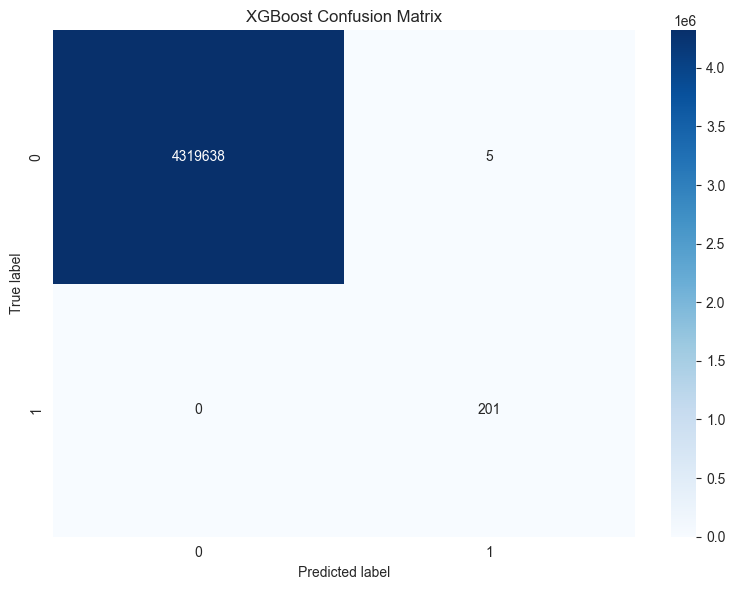

In [22]:
plot_confusion_matrix(y_test_encoded, y_pred_lgbm, label_encoder.classes_, "XGBoost Confusion Matrix")

In [31]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


def calculate_latency(model, X_test, iterations=10):
    """
     Average Prediction Latency Per Sample.


      Args:
        model: Trained model with .predict method.
        X_test: Test data.
        iterations: Number of iterations to average latency over.
      Returns:
        average_latency_per_row: The average latency per row across all iterations
    """
    total_latency = 0
    num_rows = X_test.shape[0]

    for _ in range(iterations):
        start_time = time.time()

        # Data Preparation (Dummy Preprocessing as example, replace with your processing pipeline)
        X_test_prep = X_test.copy()  # This represents your preprocessing, you can scale as you did in your code if you want.

        # Prediction step
        model.predict(X_test_prep)

        end_time = time.time()
        total_latency += (end_time - start_time)

    average_latency = total_latency / iterations
    average_latency_per_row = average_latency / num_rows
    return average_latency_per_row


average_latency_cat = calculate_latency(lgbm_model, X_test_with_graph)
average_latency_cat

1.6047420491253512e-06

In [26]:
import psutil
import os
import time


def measure_prediction_memory_cost(model, X_test):
    """
    Memory Usage During Prediction on Test Set (MB)

    Args:
      model: Trained model with .predict method.
      X_test: Test data.
    Returns:
      memory_usage_mb: The increase in memory usage during the prediction, in MB.
    """

    def get_memory_usage():
        process = psutil.Process(os.getpid())
        return process.memory_info().rss / (1024 ** 2)  # in MB

    start_memory = get_memory_usage()
    model.predict(X_test)
    end_memory = get_memory_usage()

    memory_usage_mb = end_memory - start_memory
    return memory_usage_mb


# Example usage:
# Assuming you have a trained model `model` and test data `X_test`
#  memory_cost = measure_prediction_memory_cost(model, X_test)
# print(f"Memory usage during prediction: {memory_cost:.2f} MB")
memory_cost = measure_prediction_memory_cost(lgbm_model, X_test_with_graph)
print(f"Memory usage during prediction: {memory_cost:.2f} MB")


Memory usage during prediction: 0.09 MB


In [49]:
import psutil
import os
import time


def measure_prediction_cpu_cost(model, X_test, duration=3):
    """
    Average CPU Usage During Prediction on Test Set (%)
    System CPU time during prediction on  Test Set (seconds)

    Args:
      model: Trained model with .predict method.
      X_test: Test data.
      duration : time in seconds to average cpu metrics over.
    Returns:
        cpu_percent: Average CPU usage percentage during prediction.
        user_cpu_time: User CPU time in seconds during the prediction.
        system_cpu_time: System CPU time in seconds during the prediction.
    """

    def get_cpu_usage():
        cpu_percent = psutil.cpu_percent()
        cpu_times = psutil.cpu_times()
        return cpu_percent, cpu_times.user, cpu_times.system

    cpu_usage_list = []
    user_cpu_time_list = []
    system_cpu_time_list = []

    start_time = time.time()
    while time.time() - start_time <= duration:
        cpu_percent, user_time, system_time = get_cpu_usage()
        cpu_usage_list.append(cpu_percent)
        user_cpu_time_list.append(user_time)
        system_cpu_time_list.append(system_time)
        time.sleep(0.1)  # Check cpu every 0.1 second

    start_cpu_percent, start_user_time, start_system_time = get_cpu_usage()

    start_prediction_time = time.time()
    model.predict(X_test)
    end_prediction_time = time.time()

    cpu_percent, end_user_time, end_system_time = get_cpu_usage()

    total_user_time = end_user_time - start_user_time
    total_system_time = end_system_time - start_system_time

    return np.mean(cpu_usage_list), total_user_time, total_system_time


# Example usage:
# Assuming you have a trained model `model` and test data `X_test`
# cpu_percent, user_cpu_time, system_cpu_time = measure_prediction_cpu_cost(model, X_test)
# print(f"Average CPU usage during prediction: {cpu_percent:.2f}%")
# print(f"User CPU time during prediction: {user_cpu_time:.2f} seconds")
# print(f"System CPU time during prediction: {system_cpu_time:.2f} seconds")
cpu_percent, user_cpu_time, system_cpu_time = measure_prediction_cpu_cost(lgbm_model, X_test_with_graph)
print(f"Average CPU usage during prediction: {cpu_percent:.2f}%")
print(f"User CPU time during prediction: {user_cpu_time:.2f} seconds")
print(f"System CPU time during prediction: {system_cpu_time:.2f} seconds")

Average CPU usage during prediction: 2.47%
User CPU time during prediction: 168.73 seconds
System CPU time during prediction: 5.25 seconds


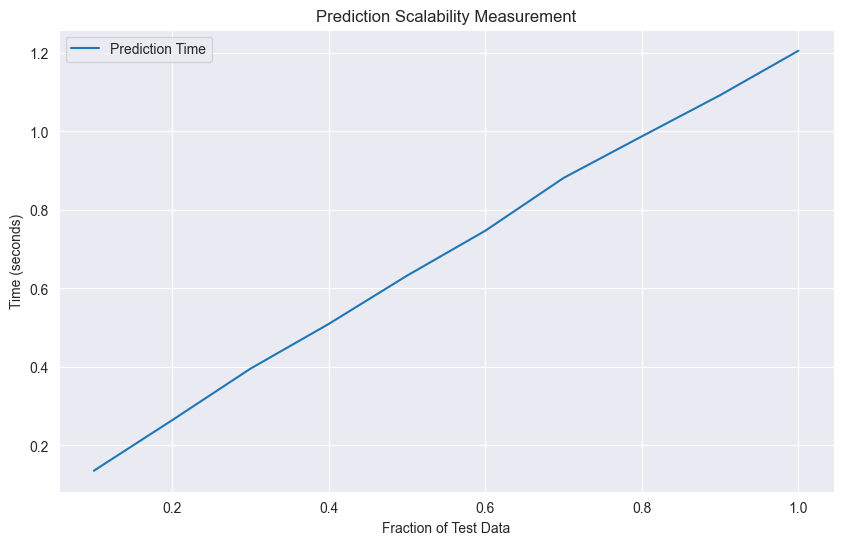

In [57]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import psutil
import os


def measure_prediction_scalability(model, X, y, test_size=0.2, sizes=np.linspace(0.1, 1, 10), iterations=3):
    """
    Measures scalability

    Args:
      model: Trained model with .predict method.
      X: Full Input dataframe.
      y: Full labels of the dataframe.
      test_size: size of the test set.
      sizes: Fractions of test data to evaluate over.
      iterations: Number of iterations to average over.
    Returns:
      sizes: Fraction of test data used in each run
      prediction_times: time taken to do predictions with each fraction of test data
    """
    prediction_times = []
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_size, random_state=42)

    for size in sizes:
        subset_size = int(len(X_test1) * size)
        X_test_subset = X_test1[:subset_size]

        total_prediction_time = 0
        for _ in range(iterations):
            start_time = time.time()
            model.predict(X_test_subset)
            end_time = time.time()
            total_prediction_time += (end_time - start_time)
        prediction_time = total_prediction_time / iterations

        prediction_times.append(prediction_time)

    return sizes, prediction_times


sizes, prediction_times = measure_prediction_scalability(lgbm_model, X_test_with_graph, y_test_encoded)
#
plt.figure(figsize=(10, 6))
plt.plot(sizes, prediction_times, label='Prediction Time')
plt.xlabel('Fraction of Test Data')
plt.ylabel('Time (seconds)')
plt.title('Prediction Scalability Measurement')
plt.legend()
plt.grid(True)
plt.show()

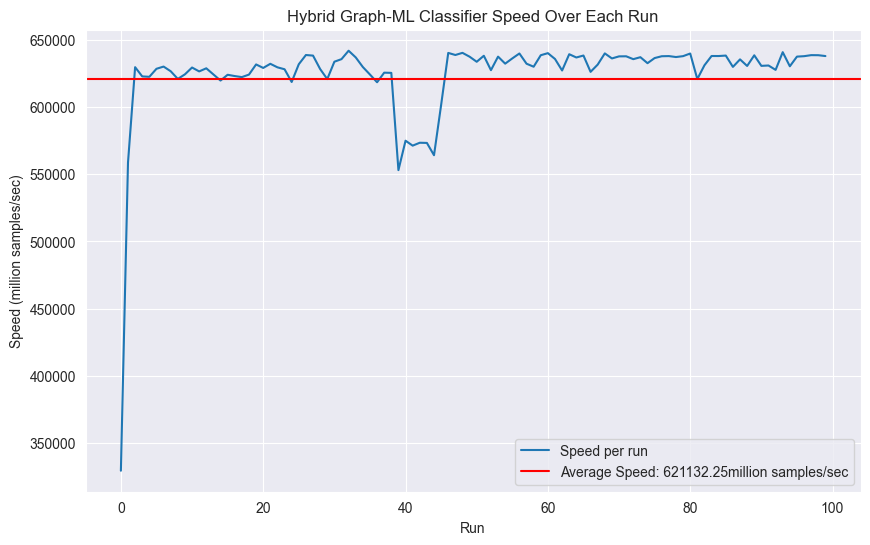

In [5]:
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd

total_elapsed_time = 0
total_samples = 0

num_runs = 100  # Define how many times you want to run the prediction
speeds = []  # List to hold the speed for each run

for _ in range(num_runs):
    if isinstance(X_test, np.ndarray):
        np.random.shuffle(X_test)  # Simple shuffling of samples

    elif isinstance(X_test, pd.DataFrame):
        X_test = X_test.sample(frac=1).reset_index(drop=True)

    start_time = time.time()
    predictions = lgbm_model.predict(X_test_with_graph)
    end_time = time.time()

    elapsed_time = end_time - start_time  # Time taken to make predictions in this run
    total_elapsed_time += elapsed_time  # Accumulating total elapsed time over all runs

    samples = X_test.shape[0]  # Number of samples in this run
    total_samples += samples  # Accumulating total number of samples over all runs

    speed = samples / elapsed_time  # Calculate speed in samples/sec for the current run
    speeds.append(speed)  # Append current speed to the list

# Calculating average speed
average_speed = total_samples / total_elapsed_time  # Calculate speed in samples/sec

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(speeds, label="Speed per run")  # Plotting speed for each run
plt.axhline(y=average_speed, color='r', linestyle='-', label=f"Average Speed: {average_speed:.2f}million samples/sec")
plt.title("Hybrid Graph-ML Classifier Speed Over Each Run")
plt.xlabel("Run")
plt.ylabel("Speed (million samples/sec)")
plt.legend()
plt.show()
